In [141]:
import os, re, time
from pathlib import Path
from typing import Optional, List, Dict, Any
import json, time, random, requests

import numpy as np
import pandas as pd
import requests
from tqdm.auto import tqdm
from pydantic import BaseModel, Field, ValidationError, conint, conlist
import matplotlib.pyplot as plt

USE_LOCAL = True
OLLAMA_MODEL = "qwen2.5:3b-instruct"   
OLLAMA_URL = "http://127.0.0.1:11434"

OPENAI_MODEL = "gpt-4o-mini"          
# export OPENAI_API_KEY

DATA_PATH = "hosts_dataset.json"      
SUMMARIES_PATH = "summaries.jsonl"    # Cache of results
CSV_EXPORT_PATH = "summaries.csv"



In [142]:
llm = OllamaAdapter(OLLAMA_MODEL, OLLAMA_URL) if USE_LOCAL else OpenAIAdapter(OPENAI_MODEL)
print("LLM:", type(llm).__name__)
#Return LLM model running locally

LLM: OllamaAdapter


In [143]:
data_path = Path(DATA_PATH)
assert data_path.exists(), f"File not found: {data_path.resolve()}"

with open(data_path, "r") as f:
    raw = json.load(f)

# Support both {"hosts":[...]} and bare list [...]
hosts = raw.get("hosts", raw)
assert isinstance(hosts, list) and len(hosts) > 0, "No hosts found in dataset"

len(hosts), hosts[0]


(3,
 {'ip': '168.196.241.227',
  'location': {'city': 'New York City',
   'country': 'United States',
   'country_code': 'US',
   'coordinates': {'latitude': 40.71427, 'longitude': -74.00597}},
  'autonomous_system': {'asn': 263744,
   'name': 'Udasha S.A.',
   'country_code': 'HN'},
  'services': [{'port': 11558,
    'protocol': 'SSH',
    'banner': 'SSH-2.0-OpenSSH_8.7',
    'software': [{'product': 'openssh',
      'vendor': 'openbsd',
      'version': '8.7'}],
    'vulnerabilities': [{'cve_id': 'CVE-2023-38408',
      'severity': 'critical',
      'cvss_score': 9.8,
      'description': 'Known exploited vulnerability'},
     {'cve_id': 'CVE-2024-6387',
      'severity': 'high',
      'cvss_score': 8.1,
      'description': 'Known exploited vulnerability'}]}],
  'threat_intelligence': {'security_labels': ['REMOTE_ACCESS'],
   'risk_level': 'high'}})

In [144]:
df_hosts = (
    df_services.groupby(["ip","location.country","location.city","asn","as_name"], dropna=False)
               .agg(
                   open_ports=("port", lambda x: sorted({int(p) for p in x if pd.notna(p)})),
                   protocols=("protocol", lambda x: sorted({p for p in x if pd.notna(p)})),
                   tls_any=("tls", lambda x: bool(pd.Series(x).fillna(False).any())),
                   labels=("labels", "first")
               )
               .reset_index()
)

print("Services rows:", len(df_services), "| Hosts:", len(df_hosts))
df_hosts.head()


Services rows: 11 | Hosts: 3


,ip,location.country,location.city,asn,as_name,open_ports,protocols,tls_any,labels
0,1.92.135.168,China,Beijing,55990,HWCSNET Huawei Cloud Service data center,"[22, 8074, 8082]","[HTTP, SSH]",False,[]
1,1.94.62.205,China,Shanghai,55990,HWCSNET Huawei Cloud Service data center,"[21, 22, 80, 888, 3306, 8011, 37035]","[FTP, HTTP, MYSQL, SSH]",False,[]
2,168.196.241.227,United States,New York City,263744,Udasha S.A.,[11558],[SSH],False,[]


# GRAPH

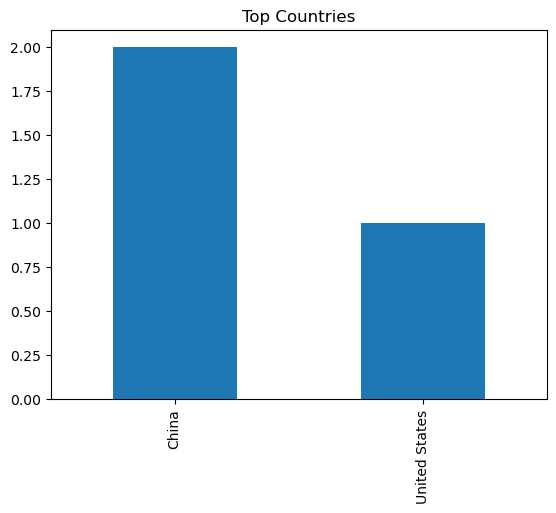

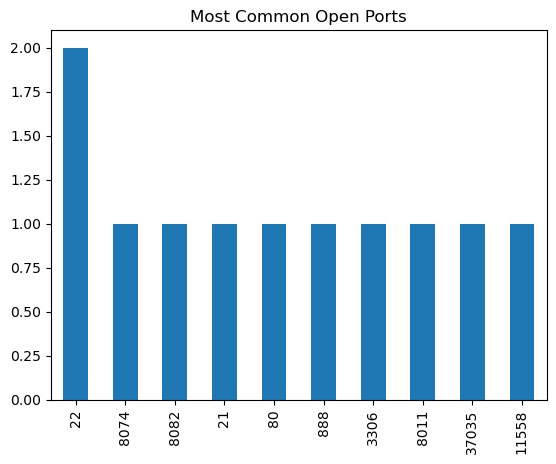

In [145]:


# Top countries
country_counts = df_hosts["location.country"].fillna("UNK").value_counts()
plt.figure()
country_counts.head(10).plot(kind="bar")
plt.title("Top Countries")
plt.show()

# Most common ports
all_ports = [p for ports in df_hosts["open_ports"] for p in ports]
if all_ports:
    ser = pd.Series(all_ports)
    plt.figure()
    ser.value_counts().head(20).plot(kind="bar")
    plt.title("Most Common Open Ports")
    plt.show()


### 3 detected security risk 2 came from China while 1 is from the US. 
### We also find out the most commonly penetrated ports are: 22, 8074, 8082, 21, 80, 888, 3306, 8011, 37035, and 11558

In [146]:
class HostSummary(BaseModel):
    host: str
    country: Optional[str] = None
    asn: Optional[int] = None
    as_name: Optional[str] = None

    open_ports: conlist(int, min_length=0) = []
    protocols: conlist(str, min_length=0) = []
    tls_present: bool = False

    notable_findings: conlist(str, min_length=0) = []
    risk_score: conint(ge=0, le=10) = 0
    brief: str

SCHEMA_TEXT = """
Return ONLY a minified JSON matching this schema:
{
  "host": "string (IP)",
  "country": "string or null",
  "asn": "integer or null",
  "as_name": "string or null",
  "open_ports": "array<int>",
  "protocols": "array<string>",
  "tls_present": "boolean",
  "notable_findings": "array<string>",
  "risk_score": "integer 0..10",
  "brief": "string (<= 300 chars)"
}
""".strip()


In [147]:
def build_prompt(row: pd.Series) -> str:
    country = row.get("location.country", row.get("country", None))
    city    = row.get("location.city",   row.get("city", None))
    asn     = row.get("asn", None)
    as_name = row.get("as_name", None)
    open_ports = row.get("open_ports", [])
    protocols  = row.get("protocols", [])
    tls_any    = row.get("tls_any", False)
    labels     = row.get("labels", [])

    # Pretty location line if city is available
    loc_str = f"{city}, {country}" if (city and country) else (country or "null")

    return f"""
You are a security analyst. Summarize one host.

INPUT:
IP: {row['ip']}
Country/City: {loc_str}
ASN: {asn}
AS Name: {as_name}
Open Ports: {open_ports}
Protocols: {protocols}
Any TLS: {tls_any}
Labels: {labels}

Guidelines:
- Risk score 0..10: consider service exposure (e.g., 22/80/443/3389), TLS, unusual ports.
- Provide 1–3 concise notable findings.
- Keep "brief" to 1–2 sentences, neutral tone.
- Return ONLY JSON. No code fences.

{SCHEMA_TEXT}
""".strip()


In [148]:

# ---------- main loop ----------
results: List[Dict[str, Any]] = list(existing.values())
new_count = 0

for _, row in df_hosts.iterrows():
    host_ip = row["ip"]
    if host_ip in existing:
        continue

    prompt = build_prompt(row)
    tries = 0
    while tries < MAX_TRIES:
        tries += 1
        time.sleep(RANDOM_JITTER_S)

        raw = send(prompt, max_tokens=600, temperature=0.1)

        try:
            payload = json.loads(extract_json(raw))
            obj = HostSummary(**payload)  # validates against schema
            out_f.write(obj.model_dump_json() + "\n")
            out_f.flush()

            rec = obj.model_dump()
            existing[host_ip] = rec
            results.append(rec)
            new_count += 1
            if new_count % 10 == 0:
                print(f"[{new_count}] summarized (latest: {host_ip})")
            break

        except Exception as ve:
            if tries < MAX_TRIES:
                prompt = _repair_prompt(row, str(ve))
                time.sleep(BACKOFF_BASE_S * (2 ** (tries - 1)) + random.random() * 0.2)
            else:
                print(f"Validation failed for {host_ip} after {tries} tries -> {ve}")

out_f.close()
print(f"Done. Total summaries: {len(existing)} (file: {sum_path.resolve()})")


Done. Total summaries: 3 (file: /Users/hokhaloi/censys-summarizer/summaries.jsonl)


,host,country,asn,as_name,open_ports,protocols,tls_present,notable_findings,risk_score,brief
0,1.92.135.168,China,55990,HWCSNET Huawei Cloud Service data center,"[22, 8074, 8082]","[HTTP, SSH]",False,"[Port 22 (SSH) is open and accessible., Port 8...",6,"Multiple ports are exposed, including SSH (22)..."
1,1.94.62.205,None,55990,HWCSNET Huawei Cloud Service data center,"[21, 22, 80, 3306, 8011, 37035]","[FTP, HTTP, MYSQL, SSH]",False,"[Port 21 (FTP) is open and not using TLS., Por...",6,"Host with open ports including FTP, HTTP, MYSQ..."
2,168.196.241.227,None,263744,Udasha S.A.,[11558],[SSH],False,"[Open SSH port on unusual port (11558), No TLS...",3,"Unusual SSH port with no TLS, located in New Y..."


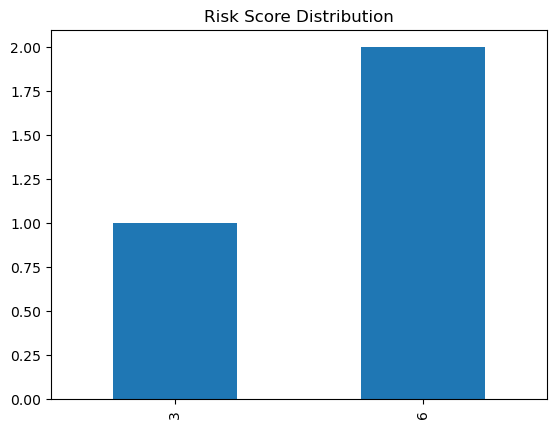

Exported: /Users/hokhaloi/censys-summarizer/summaries.csv


In [150]:
#exporting and convert json to csv file for better data analyzing
rows = [json.loads(line) for line in open(SUMMARIES_PATH)]
df_sum = pd.DataFrame(rows)

display(df_sum.head(10))

plt.figure()
df_sum["risk_score"].value_counts().sort_index().plot(kind="bar")
plt.title("Risk Score Distribution")
plt.show()

df_sum.to_csv(CSV_EXPORT_PATH, index=False)
print("Exported:", Path(CSV_EXPORT_PATH).resolve())


In [ ]:
## Out of 3 security risk, 2 of which have a score of 6 which came 1 of them from the China and the other is unknown
## One of the host with risk of of 3 also showing a 